In [1]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import fastprop
import os
from rdkit import Chem
import scipy
from matplotlib import cm
from matplotlib.colors import Normalize 
import seaborn as sns
from sklearn.metrics import mean_squared_error 
from pathlib import Path
from scipy.stats import pearsonr
import fastsolv as fastsolv
from fastsolv_analysis.util import parity_plot, solprop_parity_plot, stats, residual_cumsum, residual_dist

C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.3.1, which is newer than your current Lightning version: v2.2.4


In [2]:
matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

colors = sns.color_palette(palette='Accent').as_hex()

Set source directory

In [3]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results")

Load pre-computed predictions of Solution fastprop model predictions on the Leeds test set

In [6]:
leeds_acetone: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "fastprop_5215_predictions/leeds_acetone_fastprop_predictions.csv"))
leeds_benzene: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "fastprop_5215_predictions/leeds_benzene_fastprop_predictions.csv"))
leeds_ethanol: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "fastprop_5215_predictions/leeds_ethanol_fastprop_predictions.csv"))

fastprop_leeds_predictions = pd.concat([leeds_acetone, leeds_benzene, leeds_ethanol], ignore_index=True, axis=0) 
fastprop_leeds_predictions[['solvent_smiles', 'solute_smiles']] = fastprop_leeds_predictions['smiles'].str.split('.', n=1, expand=True)
solute_smiles = fastprop_leeds_predictions.pop('solute_smiles')  
solvent_smiles = fastprop_leeds_predictions.pop('solvent_smiles')  

both = fastprop_leeds_predictions.pop('smiles')  

fastprop_leeds_predictions.insert(0, 'solvent_smiles', solvent_smiles) 
fastprop_leeds_predictions.insert(0, 'solute_smiles', solute_smiles) 

# also load leeds features
#solprop_features: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "fastprop_5215_predictions/leeds_fastprop_nonaq.csv"))

Load pre-computed predictions of solutions chemprop model predictions on the SolProp test set

In [9]:
chemprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "chemprop_5215_predictions/solprop_chemprop_nonaq_predictions.csv"))

leeds_acetone_chemprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "chemprop_5215_predictions/leeds_acetone_chemprop_predictions.csv"))
leeds_acetone_chemprop['logS_true'] = leeds_acetone['logS_true']
leeds_benzene_chemprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "chemprop_5215_predictions/leeds_benzene_chemprop_predictions.csv"))
leeds_benzene_chemprop['logS_true'] = leeds_benzene['logS_true']
leeds_ethanol_chemprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "chemprop_5215_predictions/leeds_ethanol_chemprop_predictions.csv"))
leeds_ethanol_chemprop['logS_true'] = leeds_ethanol['logS_true']

chemprop_leeds_predictions = pd.concat([leeds_acetone_chemprop, leeds_benzene_chemprop, leeds_ethanol_chemprop], ignore_index=True, axis=0) 

Analysis of the error distributions as a funciton of various descriptors across the datasets for both the solution chemprop and fastprop models. 

In [13]:
# merged_fastprop = solprop_features.merge(fastprop_predictions, on=['solute_smiles', 'solvent_smiles', 'temperature'], how='left')
# merged_chemprop = solprop_features.merge(chemprop_predictions, on=['solute_smiles', 'solvent_smiles', 'temperature'], how='left')

# Calculate residuals for each model
fastprop_leeds_predictions['squared_residual'] = (fastprop_leeds_predictions['logS_true'] - fastprop_leeds_predictions['logS_pred'])**2
chemprop_leeds_predictions['squared_residual'] = (chemprop_leeds_predictions['logS_true'] - chemprop_leeds_predictions['logS_pred'])**2

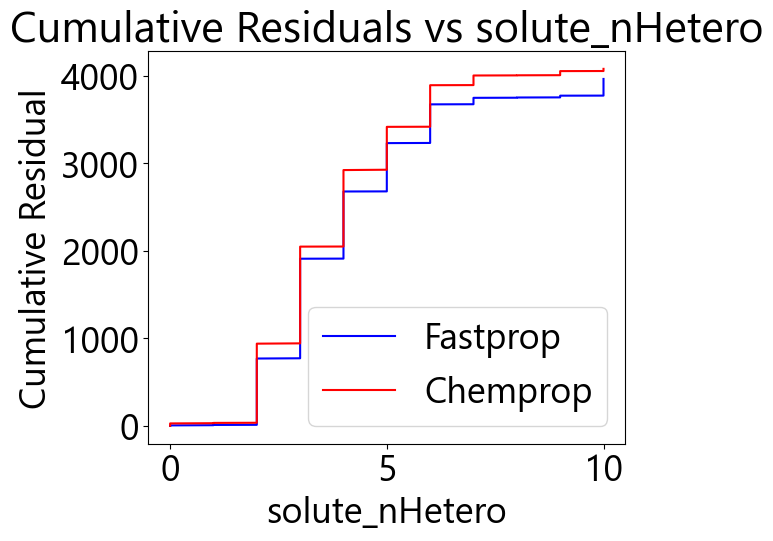

In [9]:
# residual_cumsum(merged_fastprop, merged_chemprop, 'solute_nHetero')

Analysis of the correlation between the model predictions on the Leeds test set

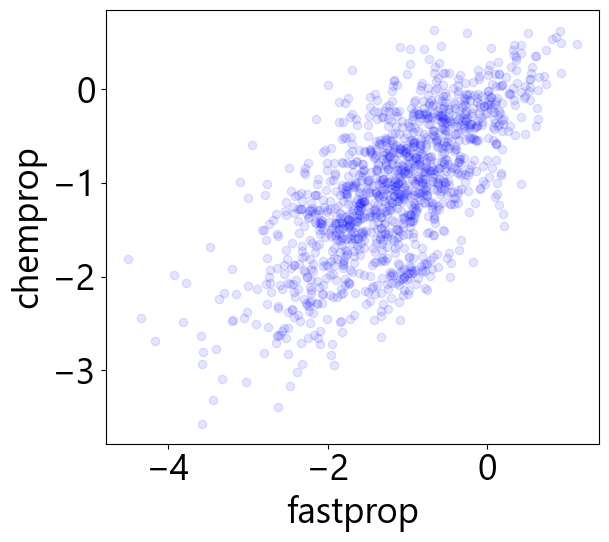

In [10]:
plt.figure(figsize=(12, 6))
r = pearsonr(fastprop_leeds_predictions['logS_pred'], chemprop_leeds_predictions['logS_pred'])
plt.subplot(1, 2, 1)
plt.scatter(fastprop_leeds_predictions['logS_pred'], chemprop_leeds_predictions['logS_pred'], color='blue', alpha = 0.1)
plt.xlabel('fastprop')
plt.ylabel('chemprop')
plt.tight_layout()
plt.show()


In [11]:
r = pearsonr(fastprop_leeds_predictions['logS_pred'], chemprop_leeds_predictions['logS_pred'])
print("Pearson R between solution chemprop and fastprop predictions on SolProp test set is: " + str(r[0]))

r = pearsonr(fastprop_leeds_predictions['logS_pred'], fastprop_leeds_predictions['logS_true'])
print("Pearson R between solution fastprop predictions and the experimental values on SolProp test set is: " + str(r[0]))

r = pearsonr(chemprop_leeds_predictions['logS_pred'], chemprop_leeds_predictions['logS_true'])
print("Pearson R between solution chemprop predictions and the experimental values on SolProp test set is: " + str(r[0]))

Pearson R between solution chemprop and fastprop predictions on SolProp test set is: 0.6827471250213291
Pearson R between solution fastprop predictions and the experimental values on SolProp test set is: 0.4931049339392073
Pearson R between solution chemprop predictions and the experimental values on SolProp test set is: 0.5299747682806668


Distribution of error as a function of log S and temperature

C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_25620\1898382695.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fastprop_error_distributions = fastprop_leeds_predictions.groupby("logS_bin")["squared_residual"].apply(list)
C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_25620\1898382695.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fastprop_per_bin_mse = np.sqrt(fastprop_leeds_predictions.groupby("logS_bin")["squared_residual"].sum() / fastprop_leeds_predictions.groupby("logS_bin")["squared_residual"].count())
C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_25620\1898382695.py:10: Future

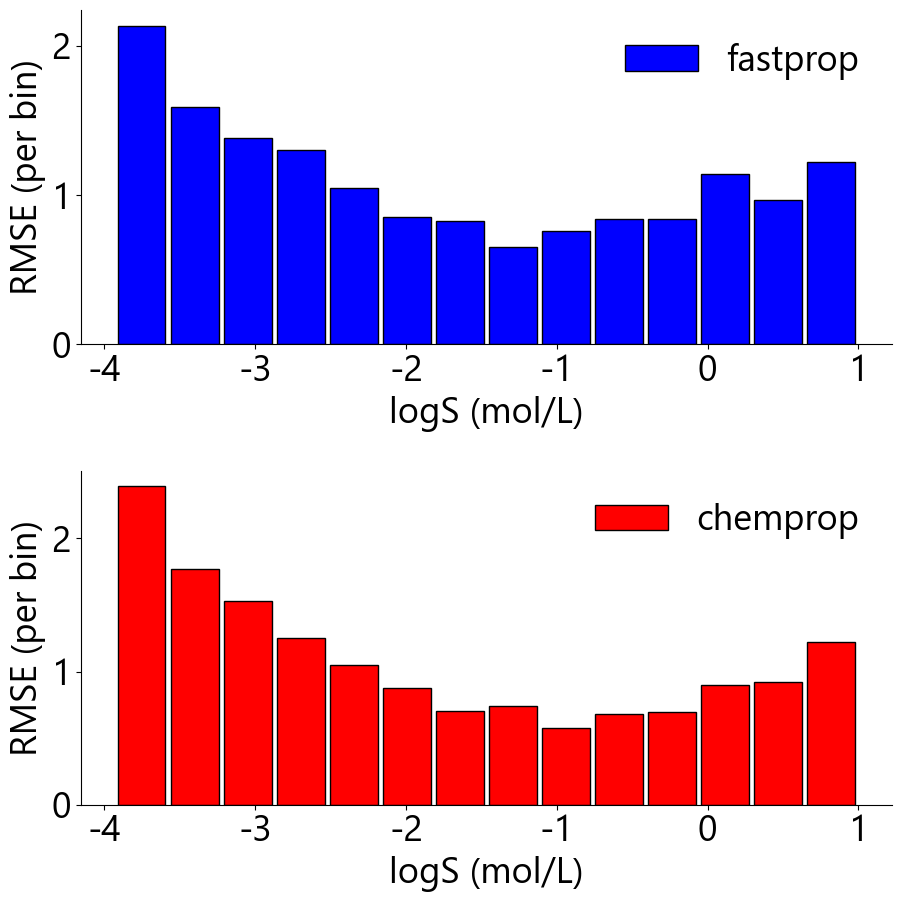

In [25]:
fastprop_bin_edges = np.linspace(fastprop_leeds_predictions['logS_true'].min(), fastprop_leeds_predictions['logS_true'].max(), 15)  # bins
fastprop_leeds_predictions["logS_bin"] = pd.cut(fastprop_leeds_predictions["logS_true"], bins=fastprop_bin_edges, include_lowest=True)
fastprop_error_distributions = fastprop_leeds_predictions.groupby("logS_bin")["squared_residual"].apply(list)
fastprop_per_bin_mse = np.sqrt(fastprop_leeds_predictions.groupby("logS_bin")["squared_residual"].sum() / fastprop_leeds_predictions.groupby("logS_bin")["squared_residual"].count())
fastprop_bin_centers = [interval.mid for interval in fastprop_per_bin_mse.index.categories]


chemprop_bin_edges = np.linspace(chemprop_leeds_predictions['logS_true'].min(), chemprop_leeds_predictions['logS_true'].max(), 15)  # bins
chemprop_leeds_predictions["logS_bin"] = pd.cut(chemprop_leeds_predictions["logS_true"], bins=chemprop_bin_edges, include_lowest=True)
chemprop_error_distributions = chemprop_leeds_predictions.groupby("logS_bin")["squared_residual"].apply(list)
chemprop_bin_centers = [interval.mid for interval in chemprop_error_distributions.index.categories]
chemprop_per_bin_mse = np.sqrt(chemprop_leeds_predictions.groupby("logS_bin")["squared_residual"].sum() / chemprop_leeds_predictions.groupby("logS_bin")["squared_residual"].count())
chemprop_bin_centers = [interval.mid for interval in chemprop_per_bin_mse.index.categories]

plt.figure(figsize=(6.4*1.5, 4.8*2))
ax1 = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1, rowspan = 1)
ax1.spines[['top', 'right',]].set_visible(False)
ax1.bar(fastprop_bin_centers, fastprop_per_bin_mse, width=np.diff(fastprop_bin_edges).mean() * 0.9, edgecolor="black", color = 'blue', alpha = 1, label = 'fastprop')
ax1.set_ylabel("RMSE (per bin)")

ax1.set_xlabel("logS (mol/L)")
#ax1.set_ylabel("Squared Error (mean per bin)")
ax1.set_xticks(
    ticks=[-4, -3, -2, -1,0, 1], 
    labels=[-4, -3, -2, -1,0, 1]
    )
ax1.set_yticks([0, 1, 2])
#ax1.set_yticks([0, 100, 200, 300])

ax1.legend(frameon= False)

ax2 = plt.subplot2grid(shape=(2,1), loc=(1,0), colspan=1, rowspan = 1)
ax2.spines[['top', 'right',]].set_visible(False)
ax2.bar(chemprop_bin_centers, chemprop_per_bin_mse, width=np.diff(chemprop_bin_edges).mean() * 0.9, edgecolor="black", color = 'red', alpha = 1, label = 'chemprop')

ax2.set_xlabel("logS (mol/L)")
ax2.set_ylabel("RMSE (per bin)")
ax2.set_yticks([0, 1, 2])
#ax2.set_yticks([0, 100, 200, 300])

ax2.set_xticks(
    ticks=[-4, -3, -2, -1,0, 1], 
    labels=[-4, -3, -2, -1,0, 1]
    )
ax2.legend(frameon= False)
plt.tight_layout()
plt.show()


C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_25620\3596435328.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fastprop_per_bin_mse = np.sqrt(fastprop_leeds_predictions.groupby("logS_bin")["squared_residual"].sum() / fastprop_leeds_predictions.groupby("logS_bin")["squared_residual"].count())
C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_25620\3596435328.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chemprop_per_bin_mse = np.sqrt(chemprop_leeds_predictions.groupby("logS_bin")["squared_residual"].sum() / chemprop_leeds_predictions.groupby("logS_bin")["squared_residual"].count())


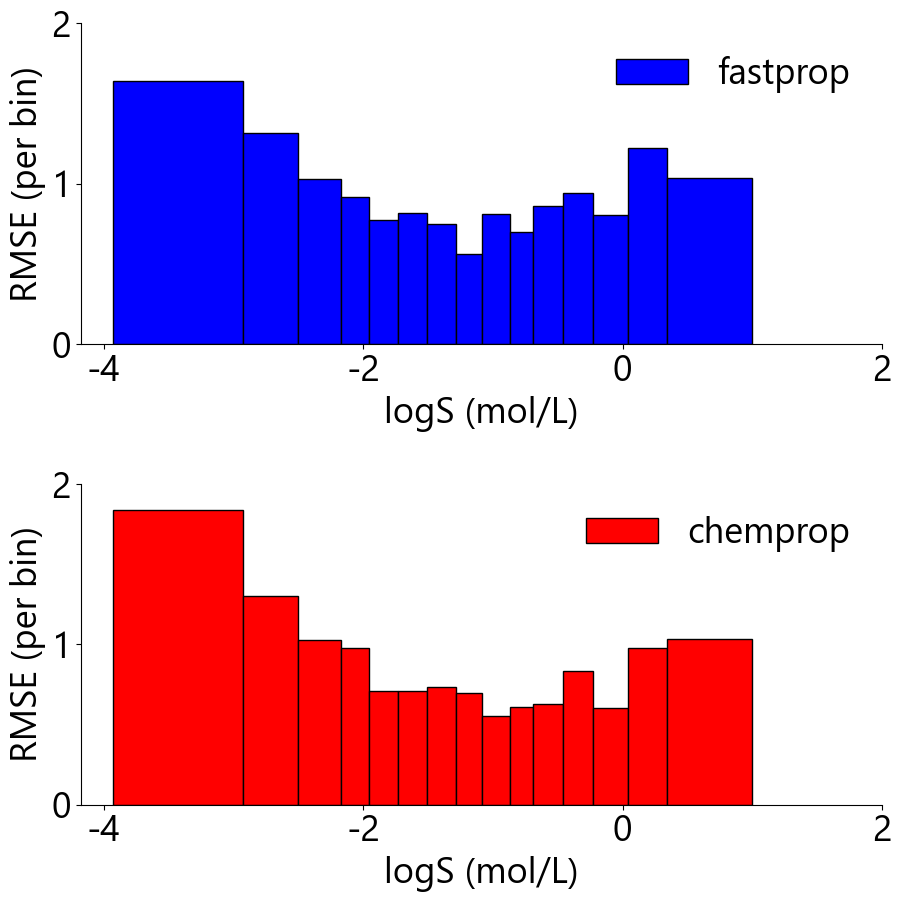

In [24]:
num_bins = 15

#fastprop_bin_edges = np.linspace(merged_fastprop['logS_true'].min(), merged_fastprop['logS_true'].max(), num_bins)  # bins
#merged_fastprop["logS_bin"] = pd.cut(merged_fastprop["logS_true"], bins=fastprop_bin_edges, include_lowest=True)
fastprop_leeds_predictions["logS_bin"] = pd.qcut(fastprop_leeds_predictions["logS_true"], q=num_bins, duplicates="drop")
#fastprop_error_distributions = merged_fastprop.groupby("logS_bin")["squared_residual"].apply(list)
fastprop_per_bin_mse = np.sqrt(fastprop_leeds_predictions.groupby("logS_bin")["squared_residual"].sum() / fastprop_leeds_predictions.groupby("logS_bin")["squared_residual"].count())
fastprop_bin_centers = [
    (interval.left + interval.right) / 2 for interval in fastprop_per_bin_mse.index.categories
]

# Get actual bin edges from qcut
fastprop_bin_edges = [interval.left for interval in fastprop_per_bin_mse.index.categories]
fastprop_bin_edges.append(fastprop_per_bin_mse.index.categories[-1].right)  # Add last edge
# Compute bin widths (difference between consecutive edges)
fastprop_bin_widths = np.diff(fastprop_bin_edges)
# Adjust bar positions to start at bin left edge
fastprop_bin_starts = fastprop_bin_edges[:-1]  # Remove last element (last edge)



#chemprop_bin_edges = np.linspace(merged_chemprop['logS_true'].min(), merged_chemprop['logS_true'].max(), num_bins)  # bins
#merged_chemprop["logS_bin"] = pd.cut(merged_chemprop["logS_true"], bins=chemprop_bin_edges, include_lowest=True)
chemprop_leeds_predictions["logS_bin"] = pd.qcut(chemprop_leeds_predictions["logS_true"], q=num_bins, duplicates="drop")
#chemprop_error_distributions = merged_chemprop.groupby("logS_bin")["squared_residual"].apply(list)
chemprop_per_bin_mse = np.sqrt(chemprop_leeds_predictions.groupby("logS_bin")["squared_residual"].sum() / chemprop_leeds_predictions.groupby("logS_bin")["squared_residual"].count())
chemprop_bin_centers = [
    (interval.left + interval.right) / 2 for interval in chemprop_per_bin_mse.index.categories
]

# Get actual bin edges from qcut
chemprop_bin_edges = [interval.left for interval in chemprop_per_bin_mse.index.categories]
chemprop_bin_edges.append(chemprop_per_bin_mse.index.categories[-1].right)  # Add last edge
# Compute bin widths (difference between consecutive edges)
chemprop_bin_widths = np.diff(chemprop_bin_edges)
# Adjust bar positions to start at bin left edge
chemprop_bin_starts = chemprop_bin_edges[:-1]  # Remove last element (last edge)



plt.figure(figsize=(6.4*1.5, 4.8*2))
ax1 = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1, rowspan = 1)
ax1.spines[['top', 'right',]].set_visible(False)
ax1.bar(fastprop_bin_starts, fastprop_per_bin_mse, width=fastprop_bin_widths, align = 'edge', edgecolor="black", color = 'blue', alpha = 1, label = 'fastprop')
ax1.set_ylabel("RMSE (per bin)")

ax1.set_xlabel("logS (mol/L)")
#ax1.set_ylabel("Squared Error (mean per bin)")
ax1.set_xticks(
    ticks=[ -4, -2, 0, 2], 
    labels=[ -4, -2, 0, 2]
    )
ax1.set_yticks([0, 1, 2])
#ax1.set_yticks([0, 100, 200, 300])

ax1.legend(frameon= False)

ax2 = plt.subplot2grid(shape=(2,1), loc=(1,0), colspan=1, rowspan = 1)
ax2.spines[['top', 'right',]].set_visible(False)
ax2.bar(chemprop_bin_starts, chemprop_per_bin_mse, width=chemprop_bin_widths, align = 'edge', edgecolor="black", color = 'red', alpha = 1, label = 'chemprop')

ax2.set_xlabel("logS (mol/L)")
ax2.set_ylabel("RMSE (per bin)")
ax2.set_yticks([0, 1, 2])
#ax2.set_yticks([0, 100, 200, 300])

ax2.set_xticks(
    ticks=[-4, -2, 0, 2], 
    labels=[-4, -2, 0, 2]
    )
ax2.legend(frameon= False)
plt.tight_layout()
plt.show()


C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_4092\1962828856.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fastprop_error_distributions = merged_fastprop.groupby("temp_bin")["squared_residual"].apply(list)
C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_4092\1962828856.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fastprop_per_bin_mse = np.sqrt(merged_fastprop.groupby("temp_bin")["squared_residual"].sum() / merged_fastprop.groupby("temp_bin")["squared_residual"].count())
C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_4092\1962828856.py:10: FutureWarning: The default of observed=Fal

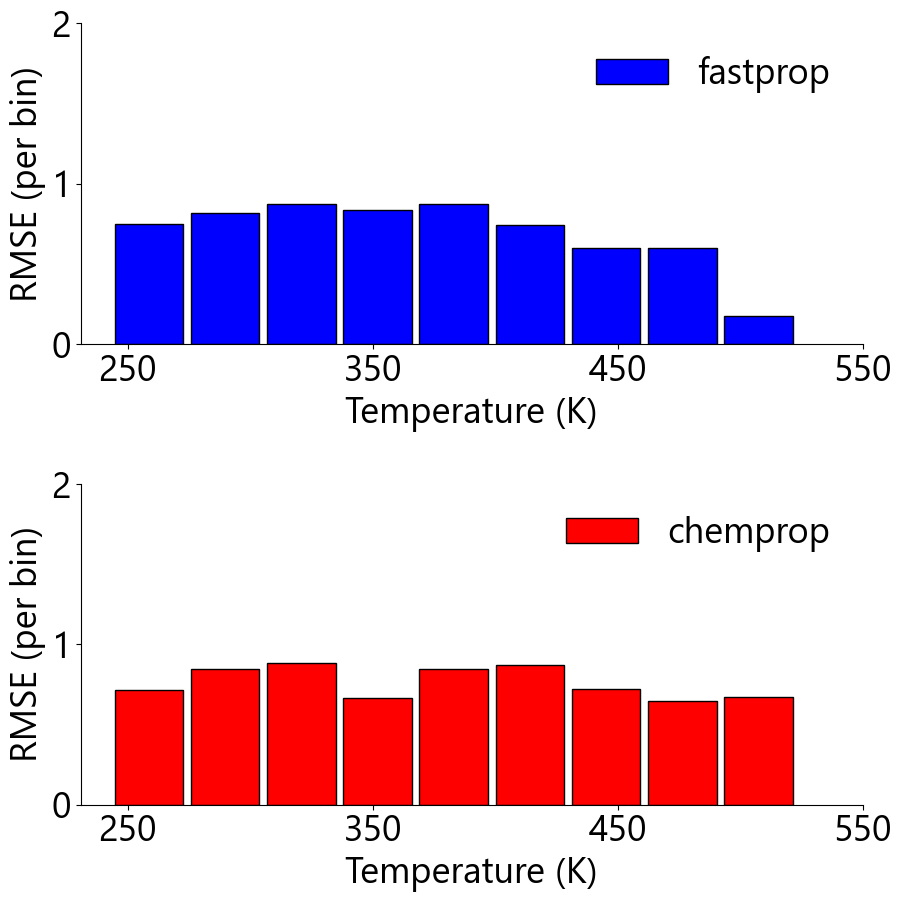

In [101]:

fastprop_bin_edges = np.linspace(merged_fastprop['temperature'].min(), merged_fastprop['temperature'].max(), 10)  # 10 bins
merged_fastprop["temp_bin"] = pd.cut(merged_fastprop["temperature"], bins=fastprop_bin_edges, include_lowest=True)
fastprop_error_distributions = merged_fastprop.groupby("temp_bin")["squared_residual"].apply(list)
fastprop_per_bin_mse = np.sqrt(merged_fastprop.groupby("temp_bin")["squared_residual"].sum() / merged_fastprop.groupby("temp_bin")["squared_residual"].count())
fastprop_bin_centers = [interval.mid for interval in fastprop_per_bin_mse.index.categories]


chemprop_bin_edges = np.linspace(merged_chemprop['temperature'].min(), merged_chemprop['temperature'].max(), 10)  # 10 bins
merged_chemprop["temp_bin"] = pd.cut(merged_chemprop["temperature"], bins=chemprop_bin_edges, include_lowest=True)
chemprop_error_distributions = merged_chemprop.groupby("temp_bin")["squared_residual"].apply(list)
chemprop_bin_centers = [interval.mid for interval in chemprop_error_distributions.index.categories]
chemprop_per_bin_mse = np.sqrt(merged_chemprop.groupby("temp_bin")["squared_residual"].sum() / merged_chemprop.groupby("temp_bin")["squared_residual"].count())
chemprop_bin_centers = [interval.mid for interval in chemprop_per_bin_mse.index.categories]

plt.figure(figsize=(6.4*1.5, 4.8*2))
ax1 = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1, rowspan = 1)
ax1.spines[['top', 'right',]].set_visible(False)
ax1.bar(fastprop_bin_centers, fastprop_per_bin_mse, width=np.diff(fastprop_bin_edges).mean() * 0.9, edgecolor="black", color = 'blue', alpha = 1, label = 'fastprop')

ax1.set_xlabel("Temperature (K)")
ax1.set_xticks(
    ticks=[250, 350, 450, 550], 
    labels=[250, 350, 450, 550]
    )
ax1.set_yticks([0, 1, 2])
#ax1.set_yticks([0, 100, 200, 300])

ax1.legend(frameon= False)
ax1.set_ylabel("RMSE (per bin)")

ax2 = plt.subplot2grid(shape=(2,1), loc=(1,0), colspan=1, rowspan = 1)
ax2.spines[['top', 'right',]].set_visible(False)
ax2.bar(chemprop_bin_centers, chemprop_per_bin_mse, width=np.diff(chemprop_bin_edges).mean() * 0.9, edgecolor="black", color = 'red', alpha = 1, label = 'chemprop')

ax2.set_xlabel("Temperature (K)")
ax2.set_ylabel("RMSE (per bin)")
ax2.set_yticks([0, 1, 2])
#ax2.set_yticks([0, 100, 200, 300])

ax2.set_xticks(
    ticks=[250, 350, 450, 550], 
    labels=[250, 350, 450, 550]
    )
ax2.legend(frameon= False)
plt.tight_layout()
plt.show()
